In [7]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Uncompress the dataset
!unzip -uq "/content/Objects.zip" -d "sample_data_HW2/"

Generated code indicated is in reference to code that was autocompleted.

In [9]:
# import the libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pandas
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder

In [10]:
# Install the Cleverhans library (provides adversarial attacks)
!pip install -qq git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Preparing metadata (setup.py) ... done


In [11]:
#Import FGMS and PGD attacks
import cleverhans

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

### Load the Dataset

In [17]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

dataset = ImageFolder(root='sample_data_HW2/Objects/', transform=transform)
print(len(dataset))

8676


In [18]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test subsets
train_indices_1, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=123)

# Split the dataset into train and validation subsets
train_indices, val_indices = train_test_split(train_indices_1, test_size=0.2, random_state=123)

In [19]:
# Create training, testing, and validation subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

In [20]:
# Create training, testing, and validation dataloaders for iterating over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

In [21]:
print(train_dataset)
print(test_dataset)
print(val_dataset)

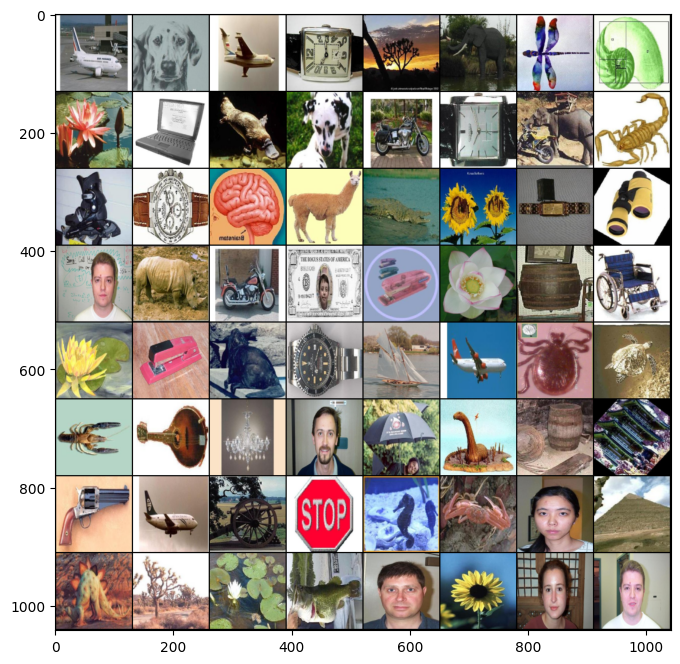

In [22]:
# show several images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of random training images and labels
images, labels = next(iter(train_dataloader))

# show images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images))

### Implement Model

In [23]:
# Import pretrained VGG16
VGG16 = vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]


In [24]:
# Change the output in the last layer to 102 classes
VGG16.classifier._modules['6'] = nn.Linear(4096, 101)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
VGG16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0
    model.train()  # Set the model to training mode

    for i, data in enumerate(train_loader):
        try:
            images, labels = data
            # Check label data type and convert if necessary
            if not isinstance(labels, torch.LongTensor):
                labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            sum_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        except Exception as e:
            print(f"Error during training: {e}")
            # Handle the exception as needed (e.g., skip the batch, stop training)

    return sum_correct / total, running_loss


# evaluate the model on the given set
def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is an evaluation step
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)

            # Compute the output: forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)

            # calculate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            sum_correct += (predicted == labels).sum().item()

    # return the accuracy and loss
    return sum_correct/total, running_loss

In [28]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG16.parameters(), lr=0.0001)

In [29]:
from tqdm import tqdm

# total number of training epochs
epoch_num = 15

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

import datetime
now = datetime.datetime.now
t = now()

# loop over the number of epochs
for epoch in tqdm(range(epoch_num), desc="Training"):

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(VGG16, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(VGG16, val_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.3f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

print('Training time: %s' % (now() - t))

Training:   7%|▋         | 1/15 [00:16<03:57, 16.97s/it]

Epoch: 1/15	 Training loss: 166.593	 Training accuracy: 56.718	 Validation accuracy: 81.124


Training:  13%|█▎        | 2/15 [00:32<03:27, 15.94s/it]

Epoch: 2/15	 Training loss: 39.351	 Training accuracy: 87.284	 Validation accuracy: 89.121


Training:  20%|██        | 3/15 [00:46<03:04, 15.41s/it]

Epoch: 3/15	 Training loss: 19.513	 Training accuracy: 93.354	 Validation accuracy: 86.744


Training:  27%|██▋       | 4/15 [01:01<02:47, 15.23s/it]

Epoch: 4/15	 Training loss: 11.313	 Training accuracy: 95.911	 Validation accuracy: 89.337


Training:  33%|███▎      | 5/15 [01:16<02:30, 15.10s/it]

Epoch: 5/15	 Training loss: 7.842	 Training accuracy: 97.677	 Validation accuracy: 89.337


Training:  40%|████      | 6/15 [01:31<02:15, 15.00s/it]

Epoch: 6/15	 Training loss: 6.452	 Training accuracy: 97.604	 Validation accuracy: 92.219


Training:  47%|████▋     | 7/15 [01:46<01:59, 14.94s/it]

Epoch: 7/15	 Training loss: 6.444	 Training accuracy: 97.749	 Validation accuracy: 89.697


Training:  53%|█████▎    | 8/15 [02:01<01:44, 14.92s/it]

Epoch: 8/15	 Training loss: 4.353	 Training accuracy: 98.469	 Validation accuracy: 89.697


Training:  60%|██████    | 9/15 [02:16<01:29, 14.94s/it]

Epoch: 9/15	 Training loss: 3.615	 Training accuracy: 98.811	 Validation accuracy: 92.075


Training:  67%|██████▋   | 10/15 [02:31<01:14, 14.95s/it]

Epoch: 10/15	 Training loss: 2.579	 Training accuracy: 98.937	 Validation accuracy: 92.003


Training:  73%|███████▎  | 11/15 [02:46<00:59, 14.93s/it]

Epoch: 11/15	 Training loss: 3.279	 Training accuracy: 99.063	 Validation accuracy: 90.274


Training:  80%|████████  | 12/15 [03:01<00:44, 14.95s/it]

Epoch: 12/15	 Training loss: 2.650	 Training accuracy: 99.171	 Validation accuracy: 89.697


Training:  87%|████████▋ | 13/15 [03:16<00:29, 14.92s/it]

Epoch: 13/15	 Training loss: 4.035	 Training accuracy: 98.847	 Validation accuracy: 91.427


Training:  93%|█████████▎| 14/15 [03:30<00:14, 14.91s/it]

Epoch: 14/15	 Training loss: 2.021	 Training accuracy: 99.207	 Validation accuracy: 89.986


Training: 100%|██████████| 15/15 [03:45<00:00, 15.05s/it]

Epoch: 15/15	 Training loss: 4.345	 Training accuracy: 98.757	 Validation accuracy: 90.346
Training time: 0:03:45.797247


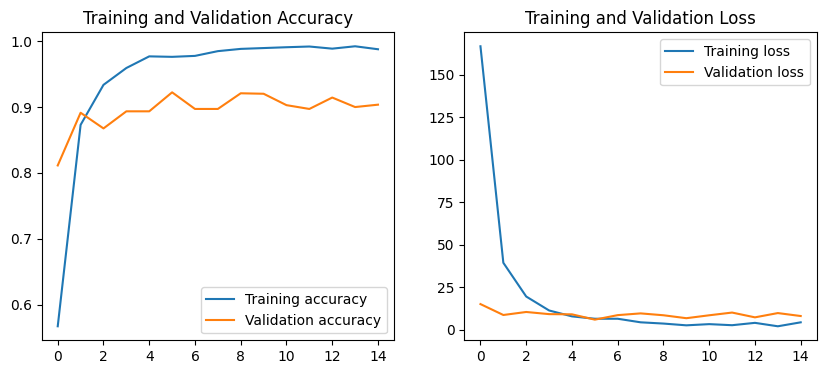

In [30]:
# plot the accuracy and loss for the training and validation datasets
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(training_accuracy_plot)
plt.plot(val_accuracy_plot)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()

In [31]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(VGG16, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 89.631


### Deep Learning Report

| Model | Train Set | Validation Set | Test Set |
| --- | --- | --- | --- |
| VGG16 | 98.757 | 90.346 | 89.631 |

### FSGM and PGD Attacks

In [32]:
epsilons = [0./255, 1./255, 3./255, 5./255, 8./255, 20./255, 50./255, 80./255]

In [33]:
# FSGM
correct = 0
total = 0
accuracies_FSGM =[]
sub_dataset = Subset(test_dataset, list(range(200)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FSGM.append(np.mean(accuracy))
print(accuracies_FSGM)

0.0
0.00392156862745098
0.011764705882352941
0.0196078431372549
0.03137254901960784
0.0784313725490196
0.19607843137254902
0.3137254901960784
[0.91484375, 0.8349766863508152, 0.7187969336891751, 0.6187138326031398, 0.5487521783463106, 0.49327207758615443, 0.4387347148461652, 0.3874377033374825]


In [34]:
# PGD
correct = 0
total = 0
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list(range(200)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter=60, norm = np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0.0
0.00392156862745098
0.011764705882352941
0.0196078431372549
0.03137254901960784
0.0784313725490196
0.19607843137254902
0.3137254901960784
[0.91484375, 0.7897113934265503, 0.5894695557626592, 0.4473092578438964, 0.3621260788736456, 0.3056086862790991, 0.26325147616092603, 0.2299202828696238]


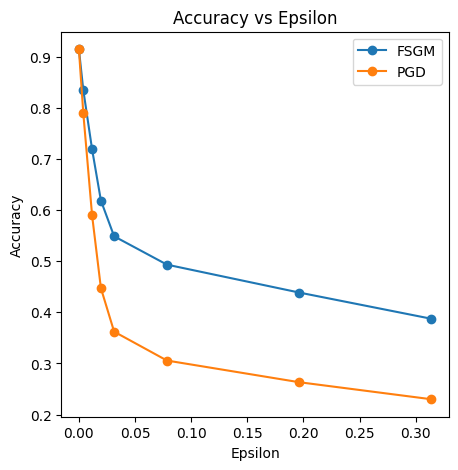

In [35]:
# FSGM-PGD plot
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_FSGM, "o-")
plt.plot(epsilons, accuracies_PGD, "o-")

plt.legend(['FSGM', 'PGD'])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

<ipython-input-36-5dea6adda688>:13: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left, bottom, right, top, wspace, hspace)


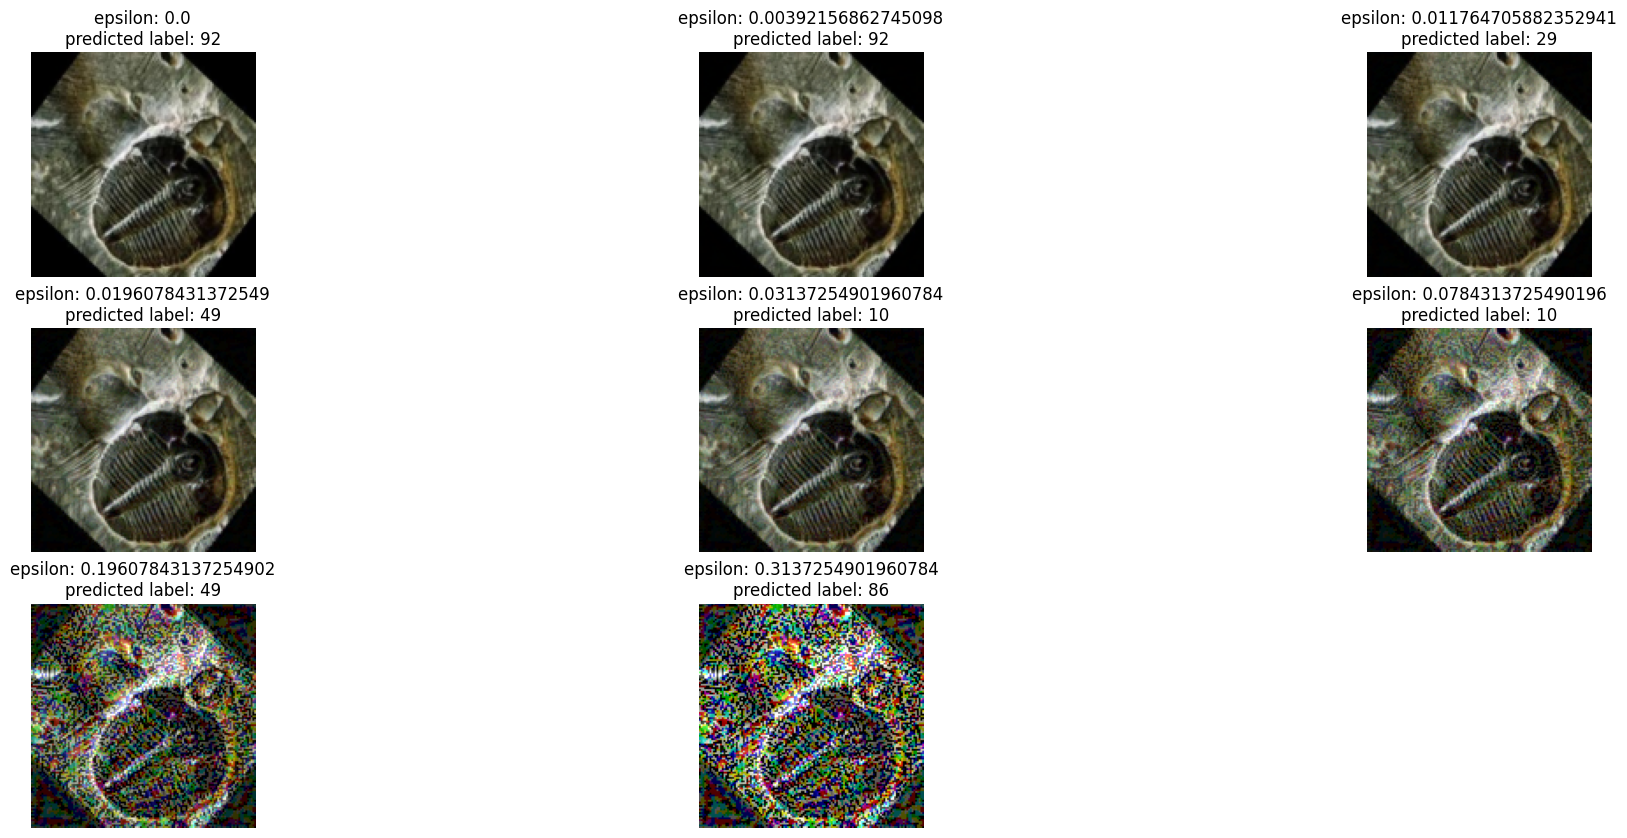

In [36]:
# FGSM - image plot

sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)
plt.figure(figsize=(20,15), constrained_layout=True)
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for data in subsest_dataloader:
  for epsilon in epsilons:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 3, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str(label))

    plt.axis('off')
    cnt +=1
  break

### FGSM and PGD Report
| Model | Clean Images | ϵ=1/255 | ϵ=5/255 | ϵ=8/255 |
| --- | --- | --- | --- | --- |
| FGSM Attack | 91.484375 | 83.49766863508152 | 61.87138326031398 | 54.87521783463106 |
| PGD Attack | 91.484375 | 78.97113934265503 | 44.73092578438964 | 36.21260788736456 |

### Carlini & Wagner L2 Attack

In [40]:
INF = float("inf")


def carlini_wagner_l2(
    model_fn,
    x,
    n_classes,
    y=None,
    targeted=False,
    lr=5e-3,
    confidence=0,
    clip_min=0,
    clip_max=1,
    initial_const=1e-2,
    binary_search_steps=5,
    max_iterations=1000,
):
    """
    This attack was originally proposed by Carlini and Wagner. It is an
    iterative attack that finds adversarial examples on many defenses that
    are robust to other attacks.
    Paper link: https://arxiv.org/abs/1608.04644

    At a high level, this attack is an iterative attack using Adam and
    a specially-chosen loss function to find adversarial examples with
    lower distortion than other attacks. This comes at the cost of speed,
    as this attack is often much slower than others.

    :param model_fn: a callable that takes an input tensor and returns
              the model logits. The logits should be a tensor of shape
              (n_examples, n_classes).
    :param x: input tensor of shape (n_examples, ...), where ... can
              be any arbitrary dimension that is compatible with
              model_fn.
    :param n_classes: the number of classes.
    :param y: (optional) Tensor with true labels. If targeted is true,
              then provide the target label. Otherwise, only provide
              this parameter if you'd like to use true labels when
              crafting adversarial samples. Otherwise, model predictions
              are used as labels to avoid the "label leaking" effect
              (explained in this paper:
              https://arxiv.org/abs/1611.01236). If provide y, it
              should be a 1D tensor of shape (n_examples, ).
              Default is None.
    :param targeted: (optional) bool. Is the attack targeted or
              untargeted? Untargeted, the default, will try to make the
              label incorrect. Targeted will instead try to move in the
              direction of being more like y.
    :param lr: (optional) float. The learning rate for the attack
              algorithm. Default is 5e-3.
    :param confidence: (optional) float. Confidence of adversarial
              examples: higher produces examples with larger l2
              distortion, but more strongly classified as adversarial.
              Default is 0.
    :param clip_min: (optional) float. Minimum float value for
              adversarial example components. Default is 0.
    :param clip_max: (optional) float. Maximum float value for
              adversarial example components. Default is 1.
    :param initial_const: The initial tradeoff-constant to use to tune the
              relative importance of size of the perturbation and
              confidence of classification. If binary_search_steps is
              large, the initial constant is not important. A smaller
              value of this constant gives lower distortion results.
              Default is 1e-2.
    :param binary_search_steps: (optional) int. The number of times we
              perform binary search to find the optimal tradeoff-constant
              between norm of the perturbation and confidence of the
              classification. Default is 5.
    :param max_iterations: (optional) int. The maximum number of
              iterations. Setting this to a larger value will produce
              lower distortion results. Using only a few iterations
              requires a larger learning rate, and will produce larger
              distortion results. Default is 1000.
    """

    def compare(pred, label, is_logits=False):
        """
        A helper function to compare prediction against a label.
        Returns true if the attack is considered successful.

        :param pred: can be either a 1D tensor of logits or a predicted
                class (int).
        :param label: int. A label to compare against.
        :param is_logits: (optional) bool. If True, treat pred as an
                array of logits. Default is False.
        """

        # Convert logits to predicted class if necessary
        if is_logits:
            pred_copy = pred.clone().detach()
            pred_copy[label] += -confidence if targeted else confidence
            pred = torch.argmax(pred_copy)

        return pred == label if targeted else pred != label

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        pred = model_fn(x)
        y = torch.argmax(pred, 1)

    # Initialize some values needed for binary search on const
    lower_bound = [0.0] * len(x)
    upper_bound = [1e10] * len(x)
    const = x.new_ones(len(x), 1) * initial_const

    o_bestl2 = [INF] * len(x)
    o_bestscore = [-1.0] * len(x)
    x = torch.clamp(x, clip_min, clip_max)
    ox = x.clone().detach()  # save the original x
    o_bestattack = x.clone().detach()

    # Map images into the tanh-space
    x = (x - clip_min) / (clip_max - clip_min)
    x = torch.clamp(x, 0, 1)
    x = x * 2 - 1
    x = torch.arctanh(x * 0.999999)

    # Prepare some variables
    modifier = torch.zeros_like(x, requires_grad=True)
    y_onehot = torch.nn.functional.one_hot(y, n_classes).to(torch.float)

    # Define loss functions and optimizer
    f_fn = lambda real, other, targeted: torch.max(
        ((other - real) if targeted else (real - other)) + confidence,
        torch.tensor(0.0).to(real.device),
    )
    l2dist_fn = lambda x, y: torch.pow(x - y, 2).sum(list(range(len(x.size())))[1:])
    optimizer = torch.optim.Adam([modifier], lr=lr)

    # Outer loop performing binary search on const
    for outer_step in range(binary_search_steps):
        # Initialize some values needed for the inner loop
        bestl2 = [INF] * len(x)
        bestscore = [-1.0] * len(x)

        # Inner loop performing attack iterations
        for i in range(max_iterations):
            # One attack step
            new_x = (torch.tanh(modifier + x) + 1) / 2
            new_x = new_x * (clip_max - clip_min) + clip_min
            logits = model_fn(new_x)

            real = torch.sum(y_onehot * logits, 1)
            other, _ = torch.max((1 - y_onehot) * logits - y_onehot * 1e4, 1)

            optimizer.zero_grad()
            f = f_fn(real, other, targeted)
            l2 = l2dist_fn(new_x, ox)
            loss = (const * f + l2).sum()
            loss.backward()
            optimizer.step()

            # Update best results
            for n, (l2_n, logits_n, new_x_n) in enumerate(zip(l2, logits, new_x)):
                y_n = y[n]
                succeeded = compare(logits_n, y_n, is_logits=True)
                if l2_n < o_bestl2[n] and succeeded:
                    pred_n = torch.argmax(logits_n)
                    o_bestl2[n] = l2_n
                    o_bestscore[n] = pred_n
                    o_bestattack[n] = new_x_n
                    # l2_n < o_bestl2[n] implies l2_n < bestl2[n] so we modify inner loop variables too
                    bestl2[n] = l2_n
                    bestscore[n] = pred_n
                elif l2_n < bestl2[n] and succeeded:
                    bestl2[n] = l2_n
                    bestscore[n] = torch.argmax(logits_n)

        # Binary search step
        for n in range(len(x)):
            y_n = y[n]

            if compare(bestscore[n], y_n) and bestscore[n] != -1:
                # Success, divide const by two
                upper_bound[n] = min(upper_bound[n], const[n])
                if upper_bound[n] < 1e9:
                    const[n] = (lower_bound[n] + upper_bound[n]) / 2
            else:
                # Failure, either multiply by 10 if no solution found yet
                # or do binary search with the known upper bound
                lower_bound[n] = max(lower_bound[n], const[n])
                if upper_bound[n] < 1e9:
                    const[n] = (lower_bound[n] + upper_bound[n]) / 2
                else:
                    const[n] *= 10

    return o_bestattack.detach()

correct = 0
total = 0
accuracies_CWL2 =[]
sub_dataset = Subset(test_dataset, list(range(10)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = carlini_wagner_l2(model_fn = VGG16, x =images, n_classes=101, targeted=False)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CWL2.append(np.mean(accuracy))
print(accuracies_CWL2)

0.0
0.00392156862745098
0.011764705882352941
0.0196078431372549
0.03137254901960784
0.0784313725490196
0.19607843137254902
0.3137254901960784
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Carlini & Wagner Report

The goal of the Carlini & Wagner L2 attack is to find an adversarial example that is close to the original input (in terms of L2 distance) but causes the model to misclassify it. The formula for the attack finds the minimum perturbation then takes the L2 norm of the perturbation and adds it to a hyperparameter that is multiplied against a loss function that ensures that the input with the perturbation is a misclassification. The hyperparameter is used to balance the trade off between minimizing the perturbation and maximizing the effectiveness of the attack. This attack uses gradient-based optimization and iteratively updates the pertubation to minimize the referenced formula. The key differences between C&W L2 and FGSM are that FGSM is fast but less precise than C&W L2 as it does not optimize for the smallest perturbation and that FGSM uses the L∞ norm instead of the L2 norm. PGD is more powerful than FGSM but still less precise than C&W L2. It uses the same L∞ norm instead of the L2 norm that C&W L2 uses.